## AI - Project - S2DV - Group 28 and Group 50

> Sachin Kumar Gupta  21075074

> Kushagra Gupta      21075049

> Harmanjot Singh     21075037

> Ruchira Naskar      21075072

**Blood brain barrier penetration**


Problem Statement : Prediction of Binary labels of blood-brain barrier penetration(permeability) using Keras Neural Network Model and also using XGBoost for Boosting.

The blood-brain barrier (BBB) is a highly selective barrier that separates the circulating blood from the brain extracellular fluid. It plays a crucial role in maintaining the stability of the brain's internal environment and protecting it from potentially harmful substances. However, there are certain circumstances where penetration of the BBB is desired, particularly for drug delivery to treat various neurological disorders.



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

**Importing necessary packages**

In [2]:
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
import pickle
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Input
from keras.models import Sequential, Model
from keras import optimizers, regularizers, initializers
from keras.callbacks import ModelCheckpoint, Callback
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Initalising the constants**

In [3]:
NCA1 = 100
NCA2 = 50
DROPRATE = 0.2
EP = 500
BATCH_SIZE = 256
VAL_RATIO = 0.1
TEST_RATIO = 0.1

NCA1 = 100: It represents the number of neurons (or units) in the first hidden layer of a neural network model. The value of 100 indicates that there are 100 neurons in this particular layer.

NCA2 = 50: This constant represents the number of neurons in the second hidden layer of the neural network model. In this case, there are 50 neurons in this layer.

DROPRATE = 0.2: This constant represents the dropout rate in the neural network model. Dropout is a regularization technique used to prevent overfitting by randomly dropping out (setting to zero) a fraction of the neurons during training. A dropout rate of 0.2 indicates that 20% of the neurons in the model will be dropped out during training.

EP = 500: EP likely stands for epochs, which refers to the number of times the neural network model will iterate over the entire training dataset during training. In this case, the model will go through 500 epochs.

BATCH_SIZE = 256: Batch size refers to the number of training examples utilized in each iteration of the model during the training process. A batch size of 256 means that the model will process 256 training examples at a time before updating the model's parameters.

VAL_RATIO = 0.1: This constant represents the validation ratio, which indicates the proportion of the training data that will be set aside for validation during training. A validation ratio of 0.1 means that 10% of the training data will be used for validation.

TEST_RATIO = 0.1: Similarly, the test ratio represents the proportion of the entire dataset that will be reserved for testing the trained model's performance. A test ratio of 0.1 indicates that 10% of the data will be used for testing.

**Loading the BBBP Dataset**

BBBP: Binary labels of blood-brain barrier penetration(permeability).

In [4]:
bbbp_df= pd.read_csv('/kaggle/input/bbbp-dataset-ai-project/BBBP (1).csv')
print(bbbp_df.shape)
bbbp_df.head()

(2039, 4)


,num,name,label,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


The simplified molecular-input line-entry system (**SMILES**) is a specification in form of a line notation for describing the structure of chemical species using short ASCII strings. SMILES can be converted to molecular structure by using RDKIT module.

Example: 
```python
from rdkit import Chem
m = Chem.MolFromSmiles('Cc1ccccc1')
```


In [5]:
bbbp_df['label'].value_counts()

1    1560
0     479
Name: label, dtype: int64

In the dataset used we have counted the number of label values that have the value 1 whose value is **1560** and the number of label values having the value 0 is **469**

## Feature Extration

* Installing the rdkit library that will be used for feature extraction

In [6]:
# !conda install -c rdkit rdkit -y

* Here feature will be extracted for all the SMILES and will be stored in a output file.

In [7]:
# import pandas as pd
# from rdkit import Chem
# from rdkit.Chem import Descriptors

# # Read the SMILES and label from the input CSV file
# input_file = '/kaggle/input/bbbp-dataset-ai-project/BBBP (1).csv'
# output_file = 'features.csv'
# data = pd.read_csv(input_file)

# # Create a new DataFrame to store the extracted features
# output_data = pd.DataFrame()

# # Iterate over the SMILES and extract the features
# for index, row in data.iterrows():
#     smiles = row['smiles']
#     label = row['label']
#     molecule = Chem.MolFromSmiles(smiles)
    
#     # Calculate the features using RDKit descriptors
#     features = {'smiles': smiles, 'label': label}
    
#     for descriptor_name, descriptor_func in Descriptors.descList:
#         descriptor_value = descriptor_func(molecule)
#         features[descriptor_name] = descriptor_value
    
#     # Append the features to the output DataFrame
#     output_data = output_data.append(features, ignore_index=True)

# # Save the extracted features to a new CSV file
# output_data.to_csv(output_file, index=False)


## To calculate the descripter using mordred that we are using in the model

In [8]:
# !pip install mordred rdkit


**We are using the desciptor mentioned here in order to create descriptor file https://mordred-descriptor.github.io/documentation/master/descriptors.html**

1826 column will be added in the new file after extraction

In [9]:
# import pandas as pd
# from rdkit import Chem
# from mordred import Calculator, descriptors

# # Load the input CSV file
# input_file = "/content/BBBP (1).csv"
# data = pd.read_csv(input_file)

# # Extract the SMILES column
# smiles = data['smiles']

# # Initialize the calculator with desired descriptors
# calc = Calculator(descriptors, ignore_3D=True)  # You can add more descriptors if needed

# # Calculate descriptors for each SMILES molecule
# desc_list = []
# invalid_smiles = []
# for sm in smiles:
#     mol = Chem.MolFromSmiles(sm)
#     if mol is None:
#         invalid_smiles.append(sm)
#     else:
#         desc = calc(mol)
#         desc_list.append(desc)

# # Combine descriptors with original data
# output_data = pd.concat([data, pd.DataFrame(desc_list)], axis=1)

# # Save the output to a new CSV file
# output_file = "BBBP_descriptors_df.csv"
# output_data.to_csv(output_file, index=False)


## Loading molecular descriptors or Features that were already obtained.

**Descriptors dataframe contains 1625 molecular descriptors (including 3D descriptors) generated on the NCI database using Mordred python module.**


**Now we are using the obtained feature or descripters to implement the data in the model.**

In [10]:
bbbp_descriptors_df= pd.read_csv('/kaggle/input/bbbp-dataset-ai-project/BBBP_descriptors_df.csv',low_memory=False)
print(bbbp_descriptors_df.shape)
bbbp_descriptors_df.head()

(2039, 1825)


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,14.389425,11.808563,0,1,multiple fragments (SpAbs_A/SpAbs),multiple fragments (SpMax_A/SpMax),multiple fragments (SpDiam_A/SpDiam),multiple fragments (SpAD_A/SpAD),multiple fragments (SpMAD_A/SpMAD),multiple fragments (LogEE_A/LogEE),...,9.604475,52.719904,294.126082,7.173807,1900000792,25,92.0,103.0,divide by zero encountered in power (mZagreb1),4.305556
1,16.809162,13.974216,0,0,27.07079790976892,2.2954078760731984,4.590815752146396,27.07079790976892,1.176991213468214,4.006826078023401,...,9.620262,56.206491,359.141884,7.182838,1492,28,106.0,114.0,9.506944444444443,5.319444
2,20.758034,16.164169,1,1,33.465822016594636,2.5785233443199886,5.157046688639976,33.465822016594636,1.2871470006382553,4.212470854925482,...,10.513498,61.857420,361.143784,7.850952,1484,51,146.0,180.0,9.333333333333334,5.527778
3,15.775129,12.193243,0,1,26.569834753519054,2.2810418592150574,4.562083718430117,26.569834753519054,1.2652302263580502,3.9370258695924103,...,9.441849,53.624898,290.199428,6.174456,1158,24,98.0,106.0,6.194444444444445,4.833333
4,23.095142,19.875288,1,0,36.20647450941663,2.6329498486229084,5.121946098165539,36.20647450941663,1.2484991210143666,4.326727233654511,...,10.721173,82.182989,435.065569,9.256714,2212,50,164.0,203.0,11.395833333333332,6.097222


Shape of the **Features' Data**

In [11]:
data_features = bbbp_descriptors_df;
print(data_features.shape);

(2039, 1825)


In [12]:
# function to coerce all data types to numeric

def coerce_to_numeric(df, column_list):
    df[column_list] = df[column_list].apply(pd.to_numeric, errors='coerce')

In [13]:
coerce_to_numeric(bbbp_descriptors_df, bbbp_descriptors_df.columns)
bbbp_descriptors_df.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,14.389425,11.808563,0,1,NaN,NaN,NaN,NaN,NaN,NaN,...,9.604475,52.719904,294.126082,7.173807,1900000792,25,92.0,103.0,NaN,4.305556
1,16.809162,13.974216,0,0,27.070798,2.295408,4.590816,27.070798,1.176991,4.006826,...,9.620262,56.206491,359.141884,7.182838,1492,28,106.0,114.0,9.506944,5.319444
2,20.758034,16.164169,1,1,33.465822,2.578523,5.157047,33.465822,1.287147,4.212471,...,10.513498,61.857420,361.143784,7.850952,1484,51,146.0,180.0,9.333333,5.527778
3,15.775129,12.193243,0,1,26.569835,2.281042,4.562084,26.569835,1.265230,3.937026,...,9.441849,53.624898,290.199428,6.174456,1158,24,98.0,106.0,6.194444,4.833333
4,23.095142,19.875288,1,0,36.206475,2.632950,5.121946,36.206475,1.248499,4.326727,...,10.721173,82.182989,435.065569,9.256714,2212,50,164.0,203.0,11.395833,6.097222


**If the NAN values are present in the table we are changing it to 0**

In [14]:
bbbp_descriptors_df = bbbp_descriptors_df.fillna(0)
bbbp_descriptors_df.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,14.389425,11.808563,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.604475,52.719904,294.126082,7.173807,1900000792,25,92.0,103.0,0.000000,4.305556
1,16.809162,13.974216,0,0,27.070798,2.295408,4.590816,27.070798,1.176991,4.006826,...,9.620262,56.206491,359.141884,7.182838,1492,28,106.0,114.0,9.506944,5.319444
2,20.758034,16.164169,1,1,33.465822,2.578523,5.157047,33.465822,1.287147,4.212471,...,10.513498,61.857420,361.143784,7.850952,1484,51,146.0,180.0,9.333333,5.527778
3,15.775129,12.193243,0,1,26.569835,2.281042,4.562084,26.569835,1.265230,3.937026,...,9.441849,53.624898,290.199428,6.174456,1158,24,98.0,106.0,6.194444,4.833333
4,23.095142,19.875288,1,0,36.206475,2.632950,5.121946,36.206475,1.248499,4.326727,...,10.721173,82.182989,435.065569,9.256714,2212,50,164.0,203.0,11.395833,6.097222


## KNN

The k-nearest neighbors algorithm, also known as KNN or k-NN, is a non-parametric, supervised learning classifier, which uses proximity to make classifications or predictions about the grouping of an individual data point.

Accuracy: 0.8553921568627451
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.57      0.65        99
           1       0.87      0.95      0.91       309

    accuracy                           0.86       408
   macro avg       0.82      0.76      0.78       408
weighted avg       0.85      0.86      0.85       408



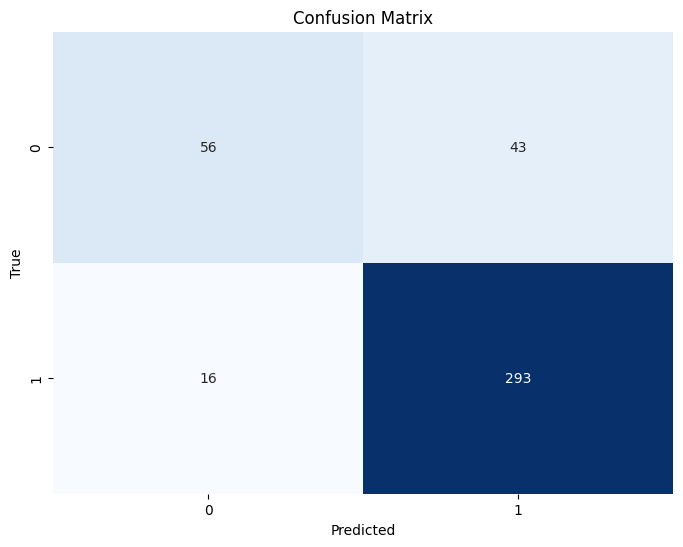

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Load the CSV files
smiles_df = pd.read_csv('/kaggle/input/bbbp-dataset-ai-project/BBBP (1).csv')
descriptor_df = pd.read_csv('/kaggle/input/bbbp-dataset-ai-project/BBBP_descriptors_df.csv')

# Step 2: Combine the data
combined_df = pd.concat([smiles_df, descriptor_df], axis=1)

# Step 3: Preprocess the data
features = combined_df.drop(['label'], axis=1)

# Remove non-numeric or string columns
numeric_cols = features.select_dtypes(include=['float64', 'int64']).columns
features = features[numeric_cols]

labels = combined_df['label']

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Step 5: Normalize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Train the KNN model
k = 5  # Number of neighbors to consider
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_scaled, y_train)

# Step 7: Predict the labels
y_pred = knn.predict(X_test_scaled)

# Step 8: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

classification_report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{classification_report}')

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Using XGBoost

Accuracy: 0.9093137254901961
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.76      0.80        99
           1       0.93      0.96      0.94       309

    accuracy                           0.91       408
   macro avg       0.89      0.86      0.87       408
weighted avg       0.91      0.91      0.91       408



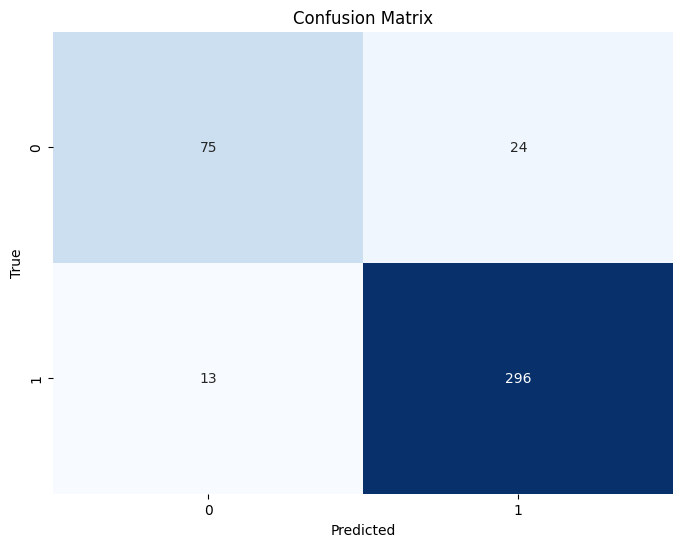

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Load the CSV files
smiles_df = pd.read_csv('/kaggle/input/bbbp-dataset-ai-project/BBBP (1).csv')
descriptor_df = pd.read_csv('/kaggle/input/bbbp-dataset-ai-project/BBBP_descriptors_df.csv')

# Step 2: Combine the data
combined_df = pd.concat([smiles_df, descriptor_df], axis=1)

# Step 3: Preprocess the data
features = combined_df.drop(['label'], axis=1)

# Remove non-numeric or string columns
numeric_cols = features.select_dtypes(include=['float64', 'int64']).columns
features = features[numeric_cols]

labels = combined_df['label']

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Step 5: Normalize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Train the XGBoost model
xgb = XGBClassifier()
xgb.fit(X_train_scaled, y_train)

# Step 7: Predict the labels
y_pred = xgb.predict(X_test_scaled)

# Step 8: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

classification_report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{classification_report}')

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## DNN Model to predict the label

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Step 1: Load the CSV files
smiles_df = pd.read_csv('/kaggle/input/bbbp-dataset-ai-project/BBBP (1).csv')
descriptor_df = pd.read_csv('/kaggle/input/bbbp-dataset-ai-project/BBBP_descriptors_df.csv')

# Step 2: Combine the data
combined_df = pd.concat([smiles_df, descriptor_df], axis=1)

# Step 3: Preprocess the data
features = combined_df.drop(['label'], axis=1)

# Remove non-numeric or string columns
numeric_cols = features.select_dtypes(include=['float64', 'int64']).columns
features = features[numeric_cols]

labels = combined_df['label']

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Step 5: Normalize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Build the DNN model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Step 7: Compile and train the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=200, batch_size=32, validation_data=(X_test_scaled, y_test))

# Step 8: Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Accuracy: {accuracy}')



Epoch 1/200
51/51 [==============================] - 1s 6ms/step - loss: 0.5062 - accuracy: 0.7836 - val_loss: 0.4687 - val_accuracy: 0.7868
Epoch 2/200
51/51 [==============================] - 0s 3ms/step - loss: 0.3877 - accuracy: 0.8498 - val_loss: 0.4040 - val_accuracy: 0.8309
Epoch 3/200
51/51 [==============================] - 0s 3ms/step - loss: 0.3395 - accuracy: 0.8731 - val_loss: 0.3764 - val_accuracy: 0.8480
Epoch 4/200
51/51 [==============================] - 0s 3ms/step - loss: 0.3258 - accuracy: 0.8694 - val_loss: 0.4030 - val_accuracy: 0.8333
Epoch 5/200
51/51 [==============================] - 0s 3ms/step - loss: 0.3102 - accuracy: 0.8780 - val_loss: 0.3591 - val_accuracy: 0.8333
Epoch 6/200
51/51 [==============================] - 0s 3ms/step - loss: 0.2969 - accuracy: 0.8823 - val_loss: 0.3409 - val_accuracy: 0.8431
Epoch 7/200
51/51 [==============================] - 0s 3ms/step - loss: 0.2893 - accuracy: 0.8835 - val_loss: 0.3365 - val_accuracy: 0.8676
Epoch 8/200
5

## GRU Model to predict the label

Epoch 1/10
51/51 [==============================] - 14s 249ms/step - loss: 0.6080 - accuracy: 0.7548 - val_loss: 0.5595 - val_accuracy: 0.7574
Epoch 2/10
51/51 [==============================] - 13s 250ms/step - loss: 0.5503 - accuracy: 0.7670 - val_loss: 0.5622 - val_accuracy: 0.7574
Epoch 3/10
51/51 [==============================] - 13s 258ms/step - loss: 0.5439 - accuracy: 0.7670 - val_loss: 0.5512 - val_accuracy: 0.7574
Epoch 4/10
51/51 [==============================] - 12s 244ms/step - loss: 0.5348 - accuracy: 0.7670 - val_loss: 0.5468 - val_accuracy: 0.7574
Epoch 5/10
51/51 [==============================] - 13s 250ms/step - loss: 0.5188 - accuracy: 0.7689 - val_loss: 0.5375 - val_accuracy: 0.7598
Epoch 6/10
51/51 [==============================] - 14s 283ms/step - loss: 0.5113 - accuracy: 0.7799 - val_loss: 0.5335 - val_accuracy: 0.7623
Epoch 7/10
51/51 [==============================] - 13s 248ms/step - loss: 1.4374 - accuracy: 0.7670 - val_loss: 0.5844 - val_accuracy: 0.7672

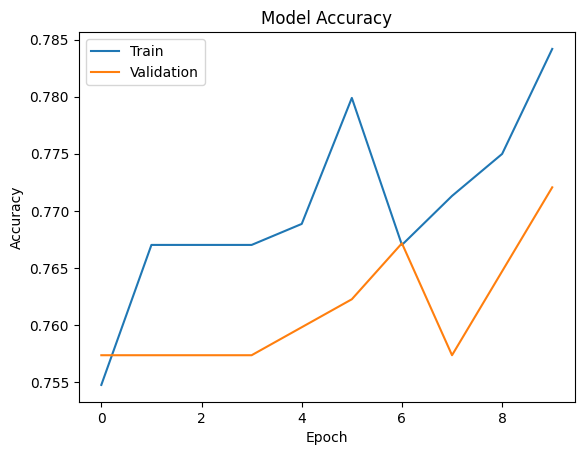

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU

# Step 1: Load the CSV files
smiles_df = pd.read_csv('/kaggle/input/bbbp-dataset-ai-project/BBBP (1).csv')
descriptor_df = pd.read_csv('/kaggle/input/bbbp-dataset-ai-project/BBBP_descriptors_df.csv')

# Step 2: Combine the data
combined_df = pd.concat([smiles_df, descriptor_df], axis=1)

# Step 3: Preprocess the data
features = combined_df.drop(['label'], axis=1)

# Remove non-numeric or string columns
numeric_cols = features.select_dtypes(include=['float64', 'int64']).columns
features = features[numeric_cols]

labels = combined_df['label']

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Step 5: Normalize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Build the GRU model
model = Sequential()
model.add(GRU(64, activation='relu', input_shape=(X_train_scaled.shape[1], 1)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Step 7: Compile and train the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled[:, :, np.newaxis], y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled[:, :, np.newaxis], y_test))

# Step 8: Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled[:, :, np.newaxis], y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Step 9: Plot the training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()




## GAN

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score


# Step 1: Load the CSV files
smiles_df = pd.read_csv('/kaggle/input/bbbp-dataset-ai-project/BBBP (1).csv')
descriptor_df = pd.read_csv('/kaggle/input/bbbp-dataset-ai-project/BBBP_descriptors_df.csv')

# Step 2: Combine the data
combined_df = pd.concat([smiles_df, descriptor_df], axis=1)

# Step 3: Preprocess the data
features = combined_df.drop(['label'], axis=1)

# Remove non-numeric or string columns
numeric_cols = features.select_dtypes(include=['float64', 'int64']).columns
features = features[numeric_cols]

labels = combined_df['label']

# Step 4: Normalize the features
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(features)

# Step 5: Define the generator model
generator = Sequential()
generator.add(Dense(64, activation='relu', input_shape=(normalized_features.shape[1],)))
generator.add(Dense(32, activation='relu'))
generator.add(Dense(normalized_features.shape[1], activation='sigmoid'))

# Step 6: Define the discriminator model
discriminator = Sequential()
discriminator.add(Dense(32, activation=LeakyReLU(alpha=0.2), input_shape=(normalized_features.shape[1],)))
discriminator.add(Dense(16, activation=LeakyReLU(alpha=0.2)))
discriminator.add(Dense(1, activation='sigmoid'))

# Step 7: Combine the generator and discriminator into a GAN
gan = Sequential()
gan.add(generator)
gan.add(discriminator)

# Step 8: Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

# Step 9: Compile the GAN
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

# Step 10: Training loop
batch_size = 32
epochs = 200

for epoch in range(epochs):
    for batch in range(len(normalized_features) // batch_size):
        # Step 10.1: Train the discriminator
        batch_features = normalized_features[batch * batch_size: (batch + 1) * batch_size]
        noise = np.random.normal(0, 1, size=(batch_size, normalized_features.shape[1]))
        generated_features = generator.predict(noise)
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))
        
        d_loss_real = discriminator.train_on_batch(batch_features, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_features, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Step 10.2: Train the generator
        noise = np.random.normal(0, 1, size=(batch_size, normalized_features.shape[1]))
        g_loss = gan.train_on_batch(noise, real_labels)
        
    # Step 10.3: Print the losses
    print(f"Epoch {epoch+1}/{epochs}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss}")
    
# Step 11: Generate synthetic samples
num_samples = 1000
noise = np.random.normal(0, 1, size=(num_samples, normalized_features.shape[1]))
generated_samples = generator.predict(noise)
generated_samples = scaler.inverse_transform(generated_samples)

# Step 12: Visualize the synthetic samples
plt.figure(figsize=(10, 6))
sns.scatterplot(x=generated_samples[:, 0], y=generated_samples[:, 1])
plt.title("Generated Samples")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()



1/1 [==============================] - 0s 17ms/step
Epoch 1/200, Discriminator Loss: 0.12213939428329468, Generator Loss: 3.326629638671875
1/1 [==============================] - 0s 15ms/step
Epoch 2/200, Discriminator Loss: 0.40298473834991455, Generator Loss: 2.902186870574951
1/1 [==============================] - 0s 15ms/step
Epoch 3/200, Discriminator Loss: 0.28989575803279877, Generator Loss: 2.674039363861084
1/1 [==============================] - 0s 17ms/step
Epoch 4/200, Discriminator Loss: 0.5508562326431274, Generator Loss: 1.9350999593734741
1/1 [==============================] - 0s 17ms/step
Epoch 5/200, Discriminator Loss: 0.6470251679420471, Generator Loss: 1.9463516473770142
1/1 [==============================] - 0s 18ms/step
Epoch 6/200, Discriminator Loss: 0.5965864658355713, Generator Loss: 1.1356755495071411
1/1 [==============================] - 0s 15ms/step
Epoch 7/200, Discriminator Loss: 0.7228600978851318, Generator Loss: 1.1777430772781372
1/1 [===============

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score


# Step 1: Load the CSV files
smiles_df = pd.read_csv('/kaggle/input/bbbp-dataset-ai-project/BBBP (1).csv')
descriptor_df = pd.read_csv('/kaggle/input/bbbp-dataset-ai-project/BBBP_descriptors_df.csv')

# Step 2: Combine the data
combined_df = pd.concat([smiles_df, descriptor_df], axis=1)

# Step 3: Preprocess the data
features = combined_df.drop(['label'], axis=1)

# Remove non-numeric or string columns
numeric_cols = features.select_dtypes(include=['float64', 'int64']).columns
features = features[numeric_cols]

labels = combined_df['label']

# Step 4: Normalize the features
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(features)

# Step 5: Define the generator model
generator = Sequential()
generator.add(Dense(64, activation='relu', input_shape=(normalized_features.shape[1],)))
generator.add(Dense(32, activation='relu'))
generator.add(Dense(normalized_features.shape[1], activation='sigmoid'))

# Step 6: Define the discriminator model
discriminator = Sequential()
discriminator.add(Dense(32, activation=LeakyReLU(alpha=0.2), input_shape=(normalized_features.shape[1],)))
discriminator.add(Dense(16, activation=LeakyReLU(alpha=0.2)))
discriminator.add(Dense(1, activation='sigmoid'))

# Step 7: Combine the generator and discriminator into a GAN
gan = Sequential()
gan.add(generator)
gan.add(discriminator)

# Step 8: Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

# Step 9: Compile the GAN
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

# Step 10: Training loop
batch_size = 32
epochs = 200

for epoch in range(epochs):
    for batch in range(len(normalized_features) // batch_size):
        # Step 10.1: Train the discriminator
        batch_features = normalized_features[batch * batch_size: (batch + 1) * batch_size]
        noise = np.random.normal(0, 1, size=(batch_size, normalized_features.shape[1]))
        generated_features = generator.predict(noise)
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))
        
        d_loss_real = discriminator.train_on_batch(batch_features, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_features, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Step 10.2: Train the generator
        noise = np.random.normal(0, 1, size=(batch_size, normalized_features.shape[1]))
        g_loss = gan.train_on_batch(noise, real_labels)
        
    # Step 10.3: Print the losses
    print(f"Epoch {epoch+1}/{epochs}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss}")


# Step 11: Generate synthetic samples
num_samples = 1000
noise = np.random.normal(0, 1, size=(num_samples, normalized_features.shape[1]))
generated_samples = generator.predict(noise)
generated_samples = scaler.inverse_transform(generated_samples)

# Step 12: Create a separate classifier model
classifier = Sequential()
classifier.add(Dense(64, activation='relu', input_shape=(normalized_features.shape[1],)))
classifier.add(Dense(32, activation='relu'))
classifier.add(Dense(1, activation='sigmoid'))

# Step 13: Compile and train the classifier on the original data
X_train, X_test, y_train, y_test = train_test_split(normalized_features, labels, test_size=0.2, random_state=42)
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier.fit(X_train, y_train, epochs=10, batch_size=32)

# Step 14: Evaluate the classifier on the generated samples
generated_samples_normalized = scaler.transform(generated_samples)
generated_samples_predictions = classifier.predict(generated_samples_normalized)
generated_samples_predictions = np.round(generated_samples_predictions).flatten()
accuracy = accuracy_score(np.ones(num_samples), generated_samples_predictions)

print(f"Accuracy on Generated Samples: {accuracy}")


## Scaling and Principal component analysis (PCA) 

In [ ]:
bbbp_scaler1 = StandardScaler()
bbbp_scaler1.fit(bbbp_descriptors_df.values)
bbbp_descriptors_df = pd.DataFrame(bbbp_scaler1.transform(bbbp_descriptors_df.values),
                                   columns=bbbp_descriptors_df.columns)

The code snippet demonstrates the process of standardizing a dataset using the StandardScaler function from the scikit-learn library in Python. Standardization is a common preprocessing step in machine learning that aims to transform the data in a way that the features have zero mean and unit variance.

In the code, the StandardScaler object bbbp_scaler1 is created. It is then fitted to the values of the bbbp_descriptors_df DataFrame using the fit() method. This step calculates the mean and standard deviation of each feature in the dataset.

Next, the transform() method is used to transform the original dataset (bbbp_descriptors_df.values) using the fitted scaler. This applies the standardization transformation to each feature in the DataFrame.

The resulting standardized dataset is assigned back to bbbp_descriptors_df, overwriting the original values. The DataFrame is now scaled, where each feature has a mean of 0 and a standard deviation of 1.

Standardization is often performed to bring different features onto a similar scale, which can be beneficial for various machine learning algorithms, such as neural networks or support vector machines, that assume the features are normally distributed or have similar scales.

In [ ]:
nca = NCA1
cn = ['col'+str(x) for x in range(nca)]

In [ ]:
bbbp_transformer1 = KernelPCA(n_components=nca, kernel='rbf', n_jobs=-1)
bbbp_transformer1.fit(bbbp_descriptors_df.values)
bbbp_descriptors_df = pd.DataFrame(bbbp_transformer1.transform(bbbp_descriptors_df.values),
                                   columns=cn)
print(bbbp_descriptors_df.shape)
bbbp_descriptors_df.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(bbbp_descriptors_df.values, bbbp_df['label'].values.flatten(), 
                                                    test_size=TEST_RATIO, 
                                                    random_state=42,stratify=bbbp_df['label'].values.flatten())

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                      test_size=VAL_RATIO, 
                                                      random_state=42,stratify=y_train)

In [ ]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

**The provided function, Find_Optimal_Cutoff, is used to determine the optimal probability cutoff point for a classification model based on the event rate.The purpose of this function is to determine the threshold (cutoff) probability that yields the optimal balance between true positive rate and false positive rate, as measured by the ROC curve.:**

In [ ]:
def Find_Optimal_threshold(target, predicted):
    target = target.reshape(-1,1)
    predicted = predicted.reshape(-1,1)
    
    rng = np.arange(0.0, 0.99, 0.001)
    f1s = np.zeros((rng.shape[0],predicted.shape[1]))
    for i in range(0,predicted.shape[1]):
        for j,t in enumerate(rng):
            p = np.array((predicted[:,i])>t, dtype=np.int8)
            scoref1 = f1_score(target[:,i], p, average='binary')
            f1s[j,i] = scoref1
            
    threshold = np.empty(predicted.shape[1])
    for i in range(predicted.shape[1]):
        threshold[i] = rng[int(np.where(f1s[:,i] == np.max(f1s[:,i]))[0][0])]
        
    return threshold

**The provided function, Find_Optimal_threshold, is used to find the optimal threshold for a binary classification model based on the F1 score This function calculates the threshold that maximizes the F1 score for each column of the predicted data, providing a threshold selection strategy based on F1 score optimization.**

## Sklearn SVC Model

**The Sklearn SVC model refers to the Support Vector Classifier model provided by the scikit-learn library in Python. SVC is a supervised machine learning algorithm used for classification tasks.**

**SVC is based on the concept of Support Vector Machines (SVM), which is a powerful algorithm for both classification and regression. In the case of classification, SVC aims to find an optimal hyperplane that separates the different classes in the feature space.**

In [ ]:
parameters = {'kernel':['sigmoid', 'rbf'], 'C':[1,0.5], 'gamma':[1/nca,1/np.sqrt(nca)],'probability':[True]}
bbbp_svc = GridSearchCV(SVC(random_state=23,class_weight='balanced'), parameters, cv=5, scoring='roc_auc',n_jobs=-1)

In [ ]:
result = bbbp_svc.fit(X_train, y_train)

In [ ]:
print(result.best_estimator_)

The best_estimator_ attribute in scikit-learn represents the best estimator or model found during the hyperparameter tuning process using methods like GridSearchCV or RandomizedSearchCV. It gives you access to the trained estimator that achieved the best performance based on the specified scoring metric.

In [ ]:
print(result.best_score_)

In [ ]:
pred = bbbp_svc.predict_proba(X_valid)

**Probability calibration:**

Some models can give poor estimates of the class probabilities and some even do not support probability prediction. The *CalibratedClassifierCV*  calibrates the probabilities of a given model, or to add support for probability prediction.

In [ ]:
bbbp_svc_calib = CalibratedClassifierCV(bbbp_svc, cv='prefit')
bbbp_svc_calib.fit(X_valid, y_valid)

In [ ]:
pred = bbbp_svc_calib.predict_proba(X_valid)
pred = pred[:,1]
pred_svc_t = np.copy(pred)

In [ ]:
threshold = Find_Optimal_threshold(y_valid, pred)
print(threshold)

In [ ]:
pred = bbbp_svc_calib.predict(X_test)
f1_score(y_test,pred)

In [ ]:
pred = bbbp_svc_calib.predict_proba(X_test)
roc_auc_score(y_test,pred[:,1])

In [ ]:
pred = pred[:,1]
pred_svc = np.copy(pred)
pred[pred<=threshold] = 0
pred[pred>threshold] = 1
svc_score = f1_score(y_test,pred)
print(svc_score)

In [ ]:
y = np.array(bbbp_descriptors_df.loc[23].values).reshape(1, -1)
result = bbbp_svc.predict(y)
prob = bbbp_svc.predict_proba(y)
print(result)
print(prob)
print(int(prob[:,1]>threshold))

## Keras Neural Network Model

In [ ]:
bbbp_model = Sequential()
bbbp_model.add(Dense(128, input_dim=bbbp_descriptors_df.shape[1], 
                     kernel_initializer='he_uniform'))
bbbp_model.add(BatchNormalization())
bbbp_model.add(Activation('tanh'))
bbbp_model.add(Dropout(rate=DROPRATE))
bbbp_model.add(Dense(64,kernel_initializer='he_uniform'))
bbbp_model.add(BatchNormalization())
bbbp_model.add(Activation('tanh'))
bbbp_model.add(Dropout(rate=DROPRATE))
bbbp_model.add(Dense(32,kernel_initializer='he_uniform'))
bbbp_model.add(BatchNormalization())
bbbp_model.add(Activation('tanh'))
bbbp_model.add(Dropout(rate=DROPRATE))
bbbp_model.add(Dense(1,kernel_initializer='he_uniform',activation='sigmoid'))

In [ ]:
bbbp_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint('bbbp_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')

In [ ]:
unique_classes = np.unique(bbbp_df['label'].values.flatten())
classes = bbbp_df['label'].values.flatten()
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(bbbp_df['label'].values.flatten()),
                                                  y = bbbp_df['label'].values.flatten())
class_weights = {unique_classes[0]:class_weights[0],unique_classes[1]:class_weights[1]}

In [ ]:
hist = bbbp_model.fit(X_train, y_train, 
                      validation_data=(X_valid,y_valid),epochs=EP, batch_size=BATCH_SIZE, 
                      class_weight=class_weights ,callbacks=[checkpoint])

In [ ]:
plt.ylim(0., 1.0)
plt.plot(hist.epoch, hist.history["loss"], label="Train loss")
plt.plot(hist.epoch, hist.history["val_loss"], label="Valid loss")

In [ ]:
bbbp_model.load_weights('bbbp_model.h5')

In [ ]:
pred = bbbp_model.predict(X_valid)
pred_nn_t = np.copy(pred)

In [ ]:
threshold = Find_Optimal_threshold(y_valid, pred)
print(threshold)

## AUC SCORE

In [ ]:
pred = bbbp_model.predict(X_test)
pred_nn = np.copy(pred)
roc_auc_score(y_test,pred)

## F1 SCORE 

In [ ]:
pred[pred<=threshold] = 0
pred[pred>threshold] = 1
nn_score = f1_score(y_test,pred)
print(nn_score)

## Accuracy

In [ ]:
from sklearn.metrics import accuracy_score

# Convert the predicted probabilities to binary predictions
pred_binary = (pred > threshold).astype(int)

# Compute accuracy
accuracy = accuracy_score(y_test, pred_binary)

# Convert accuracy to percentage
accuracy_percent = accuracy * 100

print(f'Accuracy: {accuracy_percent:.2f}%')


## Gradient Boosting of Keras Model with SVC

In [ ]:
inp = bbbp_model.input
out = bbbp_model.layers[-2].output
bbbp_model_gb = Model(inp, out)

In [ ]:
X_train = bbbp_model_gb.predict(X_train)
X_valid = bbbp_model_gb.predict(X_valid)
X_test = bbbp_model_gb.predict(X_test)

In [ ]:
data = np.concatenate((X_train,X_test,X_valid),axis=0)

In [ ]:
bbbp_scaler2 = StandardScaler()
bbbp_scaler2.fit(data)
X_train = bbbp_scaler2.transform(X_train)
X_valid = bbbp_scaler2.transform(X_valid)
X_test = bbbp_scaler2.transform(X_test)

In [ ]:
data = np.concatenate((X_train,X_test,X_valid),axis=0)

In [ ]:
nca = NCA2

In [ ]:
bbbp_transformer2 = KernelPCA(n_components=nca, kernel='rbf', n_jobs=-1)
bbbp_transformer2.fit(data)
X_train = bbbp_transformer2.transform(X_train)
X_valid = bbbp_transformer2.transform(X_valid)
X_test = bbbp_transformer2.transform(X_test)

In [ ]:
nca = X_train.shape[1]
parameters = {'kernel':['sigmoid', 'rbf'], 'C':[1,0.5], 'gamma':[1/nca,1/np.sqrt(nca)],'probability':[True]}
bbbp_svc_gb = GridSearchCV(SVC(random_state=23,class_weight='balanced'), parameters, cv=5, scoring='roc_auc',n_jobs=-1)

In [ ]:
result = bbbp_svc_gb.fit(X_train, y_train)

In [ ]:
print(result.best_estimator_)

**Best Score**

In [ ]:
print(result.best_score_)

In [ ]:
pred = bbbp_svc_gb.predict_proba(X_valid)

In [ ]:
bbbp_svc_gb_calib = CalibratedClassifierCV(bbbp_svc_gb, cv='prefit')
bbbp_svc_gb_calib.fit(X_valid, y_valid)

In [ ]:
pred = bbbp_svc_gb_calib.predict_proba(X_valid)
pred = pred[:,1]
pred_svc_gb_t = np.copy(pred)

In [ ]:
threshold = Find_Optimal_threshold(y_valid, pred)
print(threshold)

In [ ]:
pred = bbbp_svc_gb_calib.predict(X_test)
f1_score(y_test,pred)

## AUC SCORE

In [ ]:
pred = bbbp_svc_gb_calib.predict_proba(X_test)
roc_auc_score(y_test,pred[:,1])

## F1 SCORE

In [ ]:
pred = pred[:,1]
pred_svc_gb = np.copy(pred)
pred[pred<=threshold] = 0
pred[pred>threshold] = 1
svc_gb_score = f1_score(y_test,pred)
print(svc_gb_score)

## Accuracy

In [ ]:
from sklearn.metrics import accuracy_score

# Convert the predicted probabilities to binary predictions
pred_binary = (pred > threshold).astype(int)

# Compute accuracy
accuracy = accuracy_score(y_test, pred_binary)

# Convert accuracy to percentage
accuracy_percent = accuracy * 100

print(f'Accuracy: {accuracy_percent:.2f}%')


## Gradient Boosting of Keras Model with XGBoost

In [ ]:
parameters = {'learning_rate':[0.05,0.1,0.15],'n_estimators':[75,100,125], 'max_depth':[3,4,5],
               'booster':['gbtree','dart'],'reg_alpha':[0.,0.1,0.05],'reg_lambda':[0.,0.1,0.5,1.]}

bbbp_xgb_gb = GridSearchCV(XGBClassifier(random_state=32), parameters, cv=5, scoring='roc_auc',n_jobs=-1)

In [ ]:
result = bbbp_xgb_gb.fit(X_train, y_train)

In [ ]:
print(result.best_estimator_)

In [ ]:
print(result.best_score_)

In [ ]:
pred = bbbp_xgb_gb.predict_proba(X_valid)

In [ ]:
bbbp_xgb_gb_calib = CalibratedClassifierCV(bbbp_xgb_gb, cv='prefit')
bbbp_xgb_gb_calib.fit(X_valid, y_valid)

In [ ]:
pred = bbbp_xgb_gb.predict_proba(X_valid)
pred = pred[:,1]
pred_xgb_gb_t= np.copy(pred)

In [ ]:
threshold = Find_Optimal_threshold(y_valid, pred)
print(threshold)

In [ ]:
pred = bbbp_xgb_gb_calib.predict(X_test)
f1_score(y_test,pred)

In [ ]:
pred = bbbp_xgb_gb_calib.predict_proba(X_test)
roc_auc_score(y_test,pred[:,1])

In [ ]:
pred = pred[:,1]
pred_xgb_gb = np.copy(pred)
pred[pred<=threshold] = 0
pred[pred>threshold] = 1
xgb_gb_score = f1_score(y_test,pred)
print(xgb_gb_score)

In [ ]:
pred = (pred_svc_t+pred_nn_t.flatten()+pred_svc_gb_t+pred_xgb_gb_t)/4.

In [ ]:
threshold = Find_Optimal_threshold(y_valid, pred)
print(threshold)

In [ ]:
pred = (pred_svc+pred_nn.flatten()+pred_svc_gb+pred_xgb_gb)/4.
pred[pred<=threshold] = 0
pred[pred>threshold] = 1
ave_score = f1_score(y_test,pred)

## Saving models, transformer and scaler

In [ ]:
with open('bbbp_transformer1.pkl', 'wb') as fid:
    pickle.dump(bbbp_transformer1, fid)
with open('bbbp_transformer2.pkl', 'wb') as fid:
    pickle.dump(bbbp_transformer2, fid)
with open('bbbp_scaler1.pkl', 'wb') as fid:
    pickle.dump(bbbp_scaler1, fid)
with open('bbbp_scaler2.pkl', 'wb') as fid:
    pickle.dump(bbbp_scaler2, fid)
with open('bbbp_svc_calib.pkl', 'wb') as fid:
    pickle.dump(bbbp_svc_calib, fid)
with open('bbbp_svc.pkl', 'wb') as fid:
    pickle.dump(bbbp_svc, fid)
with open('bbbp_svc_gb_calib.pkl', 'wb') as fid:
    pickle.dump(bbbp_svc_gb_calib, fid)
with open('bbbp_svc_gb.pkl', 'wb') as fid:
    pickle.dump(bbbp_svc_gb, fid)
with open('bbbp_xgb_gb_calib.pkl', 'wb') as fid:
    pickle.dump(bbbp_xgb_gb_calib, fid)
with open('bbbp_xgb_gb.pkl', 'wb') as fid:
    pickle.dump(bbbp_xgb_gb, fid)

## For loading saved model

```python
with open('bbbp_svc.pkl', 'rb') as fid:
    bbbp_svc = pickle.load(fid)
 ```

## F1 Score Result

### sns.set(style="whitegrid")
ax = sns.barplot(x=[svc_score,nn_score,svc_gb_score,xgb_gb_score,ave_score],
                 y=['SVC','NN','SVC_GB','XGB_GB','ave'])
ax.set(xlim=(0.75, None))